# 线性回归：房价预测教程
理解线性层和梯度下降的本质

## 导入库和生成数据
我们要学习这个关系：**房价 = w × 面积 + b**

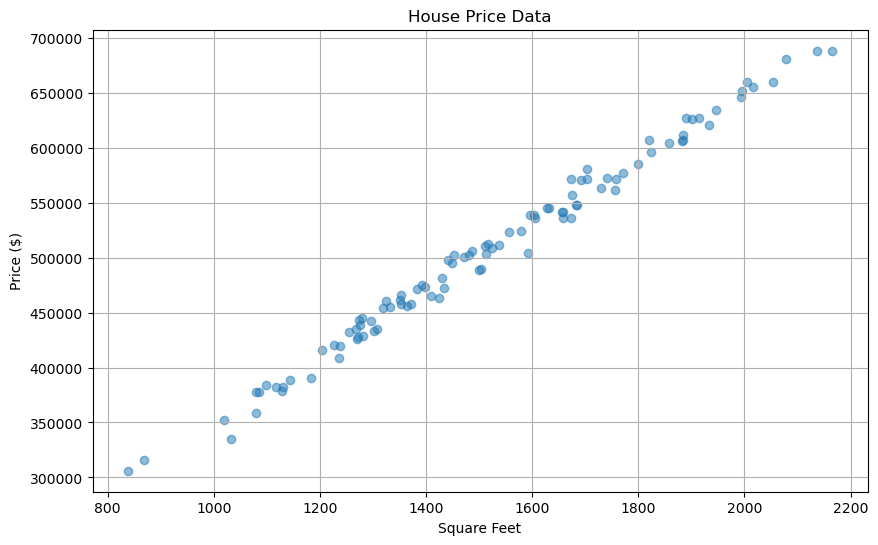

Data shape: sqft=torch.Size([100, 1]), price=torch.Size([100, 1])
True parameters: w=300.0, b=50000.0


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)

# True parameters
TRUE_W = 300.0
TRUE_B = 50000.0

# Generate data
n_samples = 100
sqft = torch.randn(n_samples, 1) * 300 + 1500
noise = torch.randn(n_samples, 1) * 10000
price = TRUE_W * sqft + TRUE_B + noise

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(sqft.numpy(), price.numpy(), alpha=0.5)
plt.xlabel('Square Feet')
plt.ylabel('Price ($)')
plt.title('House Price Data')
plt.grid(True)
plt.show()

print(f"Data shape: sqft={sqft.shape}, price={price.shape}")
print(f"True parameters: w={TRUE_W}, b={TRUE_B}")

## 方法 1：手动梯度下降

Final: w=331.99, b=1
True:  w=300.0, b=50000.0


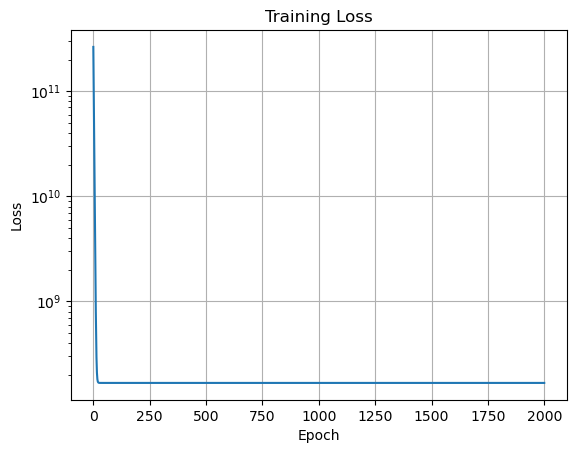

In [2]:
# Initialize
w = torch.tensor(0.0)
b = torch.tensor(0.0)
lr = 0.00000005
epochs = 2000

loss_history = []

# Training loop
for epoch in range(epochs):
    # Forward
    y_pred = w * sqft + b
    loss = ((y_pred - price) ** 2).mean()
    
    # Manual gradient
    error = y_pred - price
    grad_w = (2.0 / n_samples) * (error * sqft).sum()
    grad_b = (2.0 / n_samples) * error.sum()
    
    # Update
    w = w - lr * grad_w
    b = b - lr * grad_b
    
    loss_history.append(loss.item())

print(f"Final: w={w.item():.2f}, b={b.item():.0f}")
print(f"True:  w={TRUE_W}, b={TRUE_B}")

# Plot loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

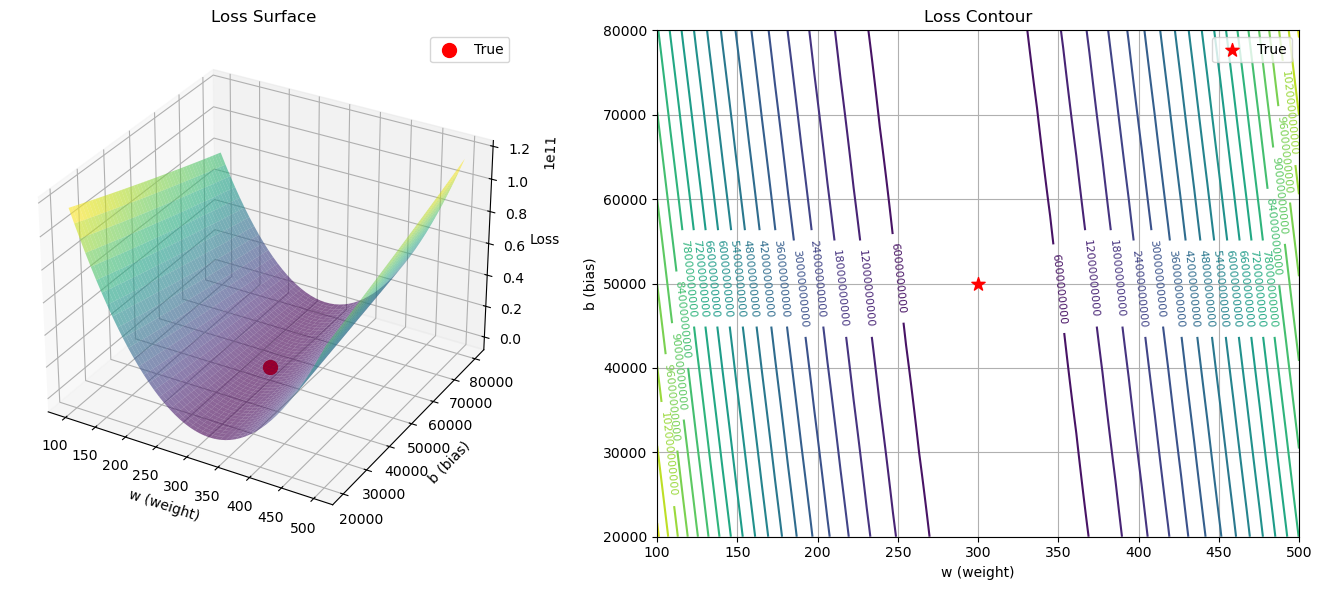

Loss at true parameters: $78,181,864


In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create grid for w and b
w_range = np.linspace(100, 500, 50)
b_range = np.linspace(20000, 80000, 50)
W, B = np.meshgrid(w_range, b_range)

# Compute loss for each (w, b) combination
Z = np.zeros_like(W)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        w_val = W[i, j]
        b_val = B[i, j]
        y_pred = w_val * sqft + b_val
        loss_val = ((y_pred - price) ** 2).mean().item()
        Z[i, j] = loss_val

# Plot 3D surface
fig = plt.figure(figsize=(14, 6))

# 3D surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(W, B, Z, cmap='viridis', alpha=0.6)
ax1.scatter([TRUE_W], [TRUE_B], [((TRUE_W * sqft + TRUE_B - price) ** 2).mean().item()], 
           color='red', s=100, label='True')
ax1.set_xlabel('w (weight)')
ax1.set_ylabel('b (bias)')
ax1.set_zlabel('Loss')
ax1.set_title('Loss Surface')
ax1.legend()

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contour(W, B, Z, levels=20, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.scatter([TRUE_W], [TRUE_B], color='red', s=100, marker='*', label='True', zorder=5)
ax2.set_xlabel('w (weight)')
ax2.set_ylabel('b (bias)')
ax2.set_title('Loss Contour')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Loss at true parameters: ${((TRUE_W * sqft + TRUE_B - price) ** 2).mean().item():,.0f}")

## 方法2：使用Autograd
关键区别： loss.backward() 自动计算梯度！
不需要手动推导 dL/dw 和 dL/db 的公式

In [4]:
# 重新生成数据
torch.manual_seed(42)
n_samples = 100
sqft = torch.randn(n_samples, 1) * 300 + 1500
noise = torch.randn(n_samples, 1) * 10000
price = TRUE_W * sqft + TRUE_B + noise

# 初始化
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# 🔥 关键：不同的学习率！
lr_w = 0.00000005  # w的学习率
lr_b = 0.015       # b的学习率（大得多！）

epochs = 2000

print(f"Initial: w={w.item()}, b={b.item()}")

for epoch in range(epochs):
    y_pred = w * sqft + b
    loss = ((y_pred - price) ** 2).mean()
    
    loss.backward()
    
    with torch.no_grad():
        w.data -= lr_w * w.grad
        b.data -= lr_b * b.grad  # 🔥 用更大的学习率
        w.grad.zero_()
        b.grad.zero_()
    
    if epoch % 400 == 0:
        print(f"Epoch {epoch}: w={w.item():.2f}, b={b.item():.2f}, loss={loss.item():.2e}")

print(f"\nFinal: w={w.item():.2f}, b={b.item():.0f}")
print(f"True:  w={TRUE_W}, b={TRUE_B}")

Initial: w=0.0, b=0.0
Epoch 0: w=79.37, b=15172.28, loss=2.64e+11
Epoch 400: w=297.44, b=54407.03, loss=7.88e+07
Epoch 800: w=298.39, b=52914.16, loss=7.84e+07
Epoch 1200: w=299.03, b=51901.64, loss=7.82e+07
Epoch 1600: w=299.47, b=51214.86, loss=7.81e+07

Final: w=299.77, b=50750
True:  w=300.0, b=50000.0


## 方法 3 使用nn.Module（推荐）


工业标准写法：

* 用 nn.Linear 定义层
* 用 optimizer.step() 更新参数
* 最容易扩展到复杂网络